# Hands on Computer Vision: Build Production-Grade Models in an Hour

This notebook demonstrates practical implementations of core computer vision tasks using pre-trained deep learning models. We'll explore the object detection task.

**Object Detection**: Locating and identifying multiple objects within an image, including their positions and classes

Each section includes:
- Loading and preprocessing images
- Using pre-trained models for inference
- Visualizing and interpreting results

Prerequisites:
- Basic Python knowledge
- Understanding of NumPy and PyTorch
- Familiarity with image processing concepts

All required dependencies are listed in the requirements.txt file of the repository.

# Setup and Imports

Before diving into computer vision tasks, let's set up our environment to access project files and utilities. This step ensures we can easily load images and use helper functions from our project structure.

In [1]:
# all imports
import sys
import torch
import random
import numpy as np
import glob as glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from urllib.request import urlopen


In [2]:
# Set up Python path to access our utility modules
# Since this notebook is in the 'notebooks' directory, we need to add the parent (repo root) 
# to the Python path to be able to import from the 'src' directory

# Get current notebook's path and add repo root to Python path
notebook_path = Path().resolve()
repo_root = notebook_path.parent.parent
sys.path.append(str(repo_root))

# Import pre-defined paths to our image directories
# These paths are defined in src/paths.py for consistent use across the project
from src.paths import CLASSIFICATION_IMAGES, DETECTION_IMAGES, SEGMENTATION_IMAGES
# path where to save the downloaded models
from src.paths import MODELS_DIR
# Now we can use these paths to access our images for each task:
# CLASSIFICATION_IMAGES - for image classification
# DETECTION_IMAGES - for object detection
# SEGMENTATION_IMAGES - for semantic segmentation

In [3]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Utility Functions for prediction and visualization

In [4]:
def predict_and_plot_pytorch(image_path, model, preprocess, class_labels, title="Model Predictions"):
    """
    Make predictions using PyTorch models and visualize results
    """
    # Load image
    image = Image.open(image_path)
    
    # Get predictions
    with torch.no_grad():
        input_tensor = preprocess(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    # Get top 5 predictions
    probs, catids = torch.topk(probabilities, 5, largest=True)
    probs = probs.cpu().numpy()[::-1]
    catids = catids.cpu().numpy()[::-1]
    
    # Create label dictionary
    labels_dict = {i: label for i, label in enumerate(class_labels)}
    
    # Plot results
    plot_predictions(image, probs, catids, labels_dict, title)

def plot_predictions(image, probs, catids, labels_dict, title):
    """
    Helper function to plot the image and predictions
    """
    plt.figure(figsize=(10, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    
    # Top 5 predictions
    plt.subplot(1, 2, 2)
    bars = plt.barh(np.arange(5), probs)
    plt.yticks(np.arange(5), [labels_dict[idx] for idx in catids])
    plt.xlabel('Probability')
    plt.title(title)
    
    # Add probability values on bars
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{bar.get_width():.3f}', 
                va='center', ha='left', fontsize=9)
    
    plt.xlim(0, max(probs) * 1.1)
    plt.tight_layout()

# Utility function to load files for any given task
def get_files_path_for_task(task):
    if task == "image_classification":
        dir_path = CLASSIFICATION_IMAGES
    elif task == "object_detection":
        dir_path = DETECTION_IMAGES
    elif task == "semantic_segmentation":
        dir_path = SEGMENTATION_IMAGES
    else:
        raise ValueError(f"Unknown task to load files: {task}")
    files = []
    for ext in ['.jpg', '.jpeg', '.png', '.webp']:
        files.extend(list(dir_path.glob(f'*{ext}')))
    
    # Sort files for consistent ordering
    files.sort()
    
    print("Found image files for task {task}: ")
    for img_path in files:
        print(f"- {img_path.name}")
    return files

def visualize_image(image_path):
    plt.figure(figsize=(8,4))
    classification_image = plt.imread(image_path)
    plt.imshow(classification_image)
    plt.axis("off")


# utility function to plot the labels in a grid
def plot_random_labels(labels_to_plot, title):
   random.seed(42)
   class_names = random.sample(labels_to_plot, 25)
    
   # Light green pastel color
   pastel_color = '#BAFFC9'
   
   fig, ax = plt.subplots(5, 5, figsize=(10, 2.5))
   fig.suptitle(title, fontsize=12, y=0.95)
   
   for i, (name, subplot) in enumerate(zip(class_names, ax.flat)):
       # Create a colored background rectangle
       subplot.add_patch(plt.Rectangle((0, 0), 1, 1, facecolor=pastel_color))
       subplot.text(0.5, 0.5, name, ha='center', va='center', fontsize=8)
       subplot.set_xticks([])
       subplot.set_yticks([])
   
   plt.tight_layout()


## Object Detection with YOLO

Object detection models generally fall into two categories: two-stage and one-stage detectors.

### Two-Stage vs One-Stage Detectors
- **Two-Stage Detectors** (like R-CNN family):
  1. First stage generates region proposals (potential object locations)
  2. Second stage classifies each proposed region
  - Generally more accurate but slower
  - Examples: Faster R-CNN, Mask R-CNN

- **One-Stage Detectors** (like YOLO):
  - Predict bounding boxes and class probabilities directly in a single pass
  - Faster but historically less accurate (though this gap has narrowed)
  - Examples: YOLO, SSD (Single Shot Detector)

For our object detection task, we'll use YOLO (You Only Look Once), which pioneered the one-stage detection approach. YOLO revolutionized object detection by being both fast and accurate, making it suitable for real-time applications.

### Why YOLO?
- **Speed**: YOLO processes images in a single pass through the network
- **Accuracy**: Achieves competitive accuracy compared to two-stage detectors
- **Real-time**: Can process images at high frame rates
- **Wide adoption**: Well-supported with many pre-trained models available

We will use YOLOv11, the latest evolution in the YOLO family. The model has been pre-trained on the COCO dataset, capable of detecting 80 different object categories including people, cars, animals, and everyday objects.

## Loading the YOLOv11 Model

We'll use the Ultralytics library to load a pre-trained YOLOv8 model. We'll use the 'yolov8n' variant, which is the smallest and fastest model in the YOLOv8 family, making it perfect for our demonstration while still providing good detection performance.

In [7]:
pip install ultralytics 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 1.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
from ultralytics import YOLO

# Load a pre-trained YOLOv11n model and save to disk so we dont need to download every time we restart this notebook
model_path = MODELS_DIR / "yolo11n.pt"
yolo11_model = YOLO(model_path)

# Set model to evaluation mode and move to correct device
yolo11_model.to(device)

print(f"YOLOv11 model loaded successfully on {device}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/hansimgluck/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:03<00:00, 1.42MB/s]


YOLOv11 model loaded successfully on cpu


## Visualize YOLO Model Classes

YOLOv8, trained on the COCO dataset, can detect 80 different classes of objects ranging from everyday items to animals, vehicles, and people. Let's look at a random sample of these classes to understand what our model can detect:


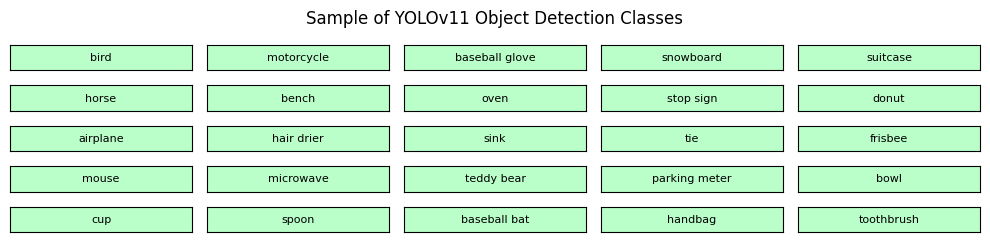

In [9]:
# Get YOLO class names
yolo_labels = list(yolo11_model.names.values())

# Display sample of class labels
plot_random_labels(yolo_labels, "Sample of YOLOv11 Object Detection Classes")

## Example Object Detection Task

In [10]:
# Get files for object detection
obj_detection_filespath = get_files_path_for_task(task = "object_detection")

Found image files for task {task}: 
- catDog.jpg
- roadTraffic.png


## Visualizing Test Sample for Object Detection

We will perform object detection on a road traffic image.

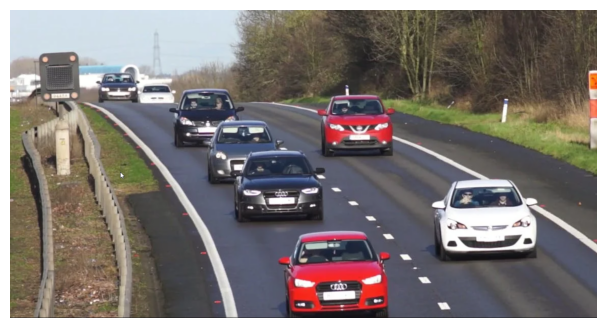

In [11]:
obj_detection_fpath = obj_detection_filespath[1] 

visualize_image(obj_detection_fpath)

## Detecting Objects with YOLO v11

In [12]:
results = yolo11_model.predict(obj_detection_fpath)

print(f"The number of objects detected in the image is:{len(results[0].boxes)}")


image 1/1 /Users/hansimgluck/Desktop/Computer_vision/data/visuals/object_detection/roadTraffic.png: 352x640 8 cars, 2 trucks, 1 traffic light, 155.6ms
Speed: 5.1ms preprocess, 155.6ms inference, 12.0ms postprocess per image at shape (1, 3, 352, 640)
The number of objects detected in the image is:11


## Check Count of Detected Objects

In [13]:
# Get results from the first prediction
result = results[0]  # Get first result
boxes = result.boxes  # Get the boxes directly from result
    
# Count objects of each class
object_counts = {}
for box in boxes:
    class_id = int(box.cls[0])
    class_name = result.names[class_id]  # Use names from result
    object_counts[class_name] = object_counts.get(class_name, 0) + 1

# Print detection summary
print("Objects detected:")
print("-" * 30)
total_objects = sum(object_counts.values())
for class_name, count in sorted(object_counts.items()):  # Sort alphabetically
    print(f"{class_name}: {count}")
print("-" * 30)
print(f"Total objects detected: {total_objects}")

Objects detected:
------------------------------
car: 8
traffic light: 1
truck: 2
------------------------------
Total objects detected: 11


## Visualize Objects With Bounding Boxes

Text(0.5, 1.0, 'Object Detection Results')

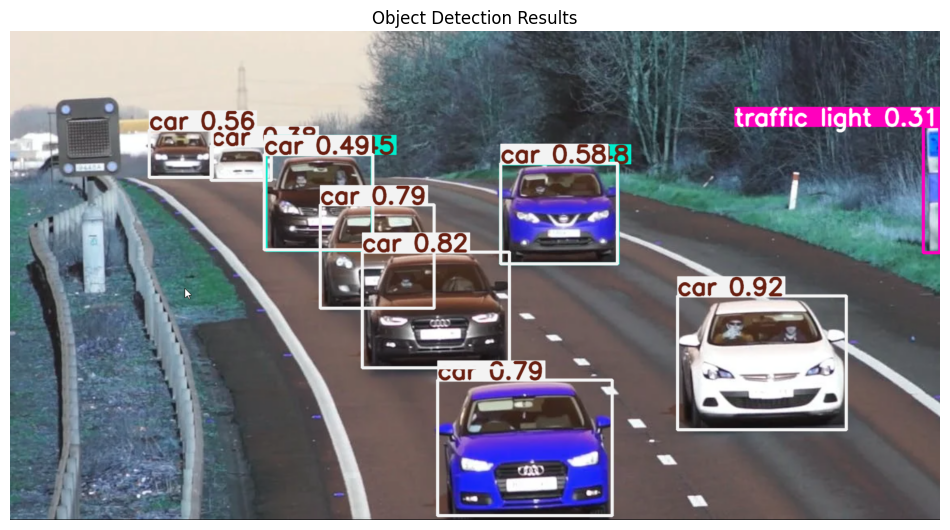

In [14]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.imshow(result.plot())  # YOLO's built-in plotting method
plt.axis('off')
plt.title("Object Detection Results")

We used YOLO v11 for object detection. By using this model, we gain several benefits:
1. Automatic Traffic Analysis: It can count the number of vehicles, detect traffic jams, and measure the speed of cars, enabling smart traffic lights and dynamic traffic management.
2. Parking Management: YOLOv8 can help in detecting available parking spots by identifying parked cars in parking lots, improving the user experience in urban areas.

And more...

These applications can significantly enhance traffic management, improve road safety, and optimize urban planning.


Voila ! You did it!
In conclusion, the versatility of leveraging pre-trained models like YOLOv11 for object detection showcase state-of-the-art performance, enabling efficient and accurate solutions for diverse computer vision tasks with minimal effort.